# Financial Backtesting

This project aim to create the backtesting function via Python. The function will be used for simulating and evaluating the performance of a `rebalancing trading strategy` on historical price data. The strategy aims to maintain a target asset allocation via triggering buy/sell actions when the allocation deviates from the target balance by a specified percentage.

## Content
- Fetching Historical Price Data.

- Develop a Backtesting Algorithms.

- Visualize the Results.

#### import essentail libraries 

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# warning hiding
import warnings
warnings.filterwarnings('ignore')

### 1. Fetch Historical Price Data

This part the API requests will be utilized to get the price data, open, high, low, close, at various times from Bitkub.

- convert typical date format to timestamp in order to determine a specific time periods.

- request (GET method) to fetch historical price data from Bitkub public endpoint.

- convert the price data into a single list.

In [2]:
# date to timestamp function
def date_to_timestamp(date_str, date_format='%Y-%m-%d %H:%M:%S'):
    date_obj = datetime.strptime(date_str, date_format)
    timestamp = int(date_obj.timestamp())
    return timestamp

# timestamp to date
def timestamp_to_date(timestamp):
    date_obj = datetime.fromtimestamp(timestamp)
    date_str = date_obj.strftime('%Y-%m-%d %H:%M:%S') 
    return date_str

# historical price function
def get_price(symbol, timeframe, date_start, date_end):
    apiHost = "https://api.bitkub.com"
    dateStart = date_to_timestamp(date_start)
    dateEnd = date_to_timestamp(date_end)
    # body = {
    #     "symbol" : symbol,
    #     "resolution" : timeframe,
    #     "from" : date_start,
    #     "to" : date_end
    # }
    response = requests.get(url= f"{apiHost}/tradingview/history?symbol={symbol}&resolution={timeframe}&from={dateStart}&to={dateEnd}")
    return response.json()

Setting input variables

the required inputs consist of 
- symbol: the trading pair symbol of crypto assets e.g BTC, ETH.

- chart timeframe: a specific timeframe for price data e.g. 1 minute, 5 minutes, 15 minutes, 60 minutes, 1 day, etc.

- date start in timestamp.

- date end in timestamp.

In [35]:
# input variables
sym = "BTC_THB"                                     # always ending with _THB  
res = "60"                                          # timeframe (1, 5, 15, 60, 240, 1D)
dateStart = "2023-01-01 00:00:00"
dateEnd = "2023-03-01 00:00:00"

# call get_price function
his_price = get_price(symbol= sym, timeframe= res, date_start= dateStart, date_end= dateEnd)

Create dataframe from responsed data.

In [36]:
# create dataframe
df = pd.DataFrame(data= his_price, columns= ["c", "h", "l", "o", "t"])

# rename all the columns
df = df.rename(columns= {
    "c" : "close",
    "h" : "high",
    "l" : "low",
    "o" : "open",
    "t" : "time_stamp"
})

# subset column
df = df[["time_stamp", "open", "high", "low", "close"]]

Convert all price data into one single list

In [37]:
# convert data to list
prices = df[["open", "high", "low", "close"]].values.tolist()

# wrap nested list to one single list 
price_lists = []
for sublist in prices:
    price_lists.extend(sublist)

### 2. Develop Backtesting Algorithm

`Main Functionality:`
- The function iterates through the price list.

- It calculates the value of the coin balance and the value of the baht balance on the current prices and allocations.

- If the coin balance exceeds or falls the threshold for rebalancing, it triggers sell or buy actions, which bring the allocation back to the target ratio.

- The function keeps track of the cash flow as a result of these buy and sell actions.

`Output:`
- The function returns a Pandas DataFrame that contains the following columns:

    - "price": The price of the asset at each time.

    - "balance": The value of the coin balance at each time.

    - "bahtBalance": The value of the baht balance at each time.

    - "side": Indicates whether the action taken at that time is a "sell," "buy," or None (no action).

    - "amount": The amount of the asset bought or sold at each trigger.
    
    - "cashFlow": The change in capital at each trigger.

`Evaluation:`
- After the backtest is complete, the function calculates performance metrics, including the maximum drawdown, the number of sell and buy triggers, the final cash flow, and the current profit percentage.

In [27]:
# write main backtest function
def rebalance_backtest(price_list, ratio, percent, capital, coinBalance):
    bahtBalance = capital
    cashFlow = bahtBalance * ratio/100
    results = []
    for a in range(len(price_list)):
        coinBalanceValue = price_list[a] * coinBalance
        balanceMark = (coinBalanceValue + bahtBalance) * ratio/100
        reSell = balanceMark + (balanceMark * percent/100)
        reBuy = balanceMark - (balanceMark * percent/100)

        if coinBalanceValue >= reSell:
            diffSell = coinBalanceValue - balanceMark
            amountSell = diffSell/price_list[a]
            coinBalance -= amountSell
            receivedusdt = amountSell * price_list[a]
            bahtBalance += receivedusdt
            if a == 0:
                cashFlow = 0
            else:
                cashFlow = (coinBalanceValue + bahtBalance) - capital
            results.append({
                #"day" : a+1,
                "price" : price_list[a],
                "balance" : coinBalanceValue,
                "bahtBalance" : bahtBalance,
                "side" : "sell",
                "amount" : amountSell,
                "cashFlow" : cashFlow
            })

        elif coinBalanceValue <= reBuy:
            diffBuy = balanceMark - coinBalanceValue
            amountBuy = diffBuy/price_list[a]
            coinBalance += amountBuy
            spentusdt = amountBuy * price_list[a]
            bahtBalance -= spentusdt
            if a == 0:
                cashFlow =0
            else:
                cashFlow = (coinBalanceValue + bahtBalance) - capital
            results.append({
                #"day" : a+1,
                "price" : price_list[a],
                "balance" : coinBalanceValue,
                "bahtBalance" : bahtBalance,
                "side" : "buy",
                "amount" : amountBuy,
                "cashFlow" : cashFlow
            })
        
        else:
            results.append({
                #"day" : a+1,
                "price" : price_list[a],
                "balance" : coinBalanceValue,
                "bahtBalance" : bahtBalance,
                "side" : None,
                "amount" : amountBuy,
                "cashFlow" : cashFlow
            })
    # crate dataframe
    result_df = pd.DataFrame(results, columns= ["price", "balance", "bahtBalance", "side", "amount", "cashFlow"])

    # evaluating
    maxDrawdown = (result_df["cashFlow"].min()/capital) * 100
    print(f"Maximum Drawdown is {maxDrawdown} %")

    print(f"{result_df['side'].value_counts().index[0]}ing trigger: {result_df['side'].value_counts()[0]}")
    print(f"{result_df['side'].value_counts().index[1]}ing trigger: {result_df['side'].value_counts()[1]}")

    cashflow = round(result_df["cashFlow"].iloc[-1], 2)
    print(f"Cash flow is {cashflow} baht")

    profit = round((cashflow/capital) * 100, 2)
    print(f"Current profit is {profit} %")
    return result_df

Inputs:
- price_list: a list containing historical price data at a specific time period.

- ratio: a percentage value (e.g., 50%) that determines the target allocation of the portfolio. It represents the target percentage allocation.

- percent: a percentage value (e.g., 1%) that defines the threshold for rebalancing. If the current allocation differ from the target allocation by this percentage or more, the strategy triggers a rebalance buy or sell.

- capital: the initial capital or investment amount in baht.

- coinBalance: the initial amount of the asset held in the portfolio.

In [38]:
RATIO = 50 # asset proportion
PERCENT = 1 # trigger condition

capital = 10000 # budget (baht valu)
coinBalance = 0 # available asset in account (baht value)

result = rebalance_backtest(price_list= price_lists, ratio= RATIO, percent= PERCENT, capital= capital, coinBalance= 0)
result

Maximum Drawdown is 0.0 %
selling trigger: 44
buying trigger: 30
Cash flow is 2132.71 baht
Current profit is 21.33 %


,price,balance,bahtBalance,side,amount,cashFlow
0,573744.83,0.000000,5000.000000,buy,0.008715,0.000000
1,573744.97,5000.001220,5000.000000,None,0.008715,0.000000
2,573350.00,4996.559185,5000.000000,None,0.008715,0.000000
3,573499.99,4997.866299,5000.000000,None,0.008715,0.000000
4,573499.98,4997.866212,5000.000000,None,0.008715,0.000000
...,...,...,...,...,...,...
5659,824181.22,6034.116075,6035.564017,None,0.000092,2132.714784
5660,824180.97,6034.114244,6035.564017,None,0.000092,2132.714784
5661,826622.54,6051.989824,6035.564017,None,0.000092,2132.714784
5662,823460.20,6028.837238,6035.564017,None,0.000092,2132.714784


### 3. Visualization

- The row will be duplicated 4 times, due to at each specific time contain 4 prices (open, high, low, close).

- Viusalize 2 charts
    - chart that show sell and buy action over the asset prices at each specific time.

    - chart exhibiting the dialy change in cash flow.

In [39]:
# duplicate more rows in order to join the tables
new_df = df.loc[df.index.repeat(4)].reset_index(drop=True)

# format datetime
new_df["time_stamp"] = pd.to_datetime(new_df["time_stamp"], unit= "s")

# join tables
full_df = new_df.join(result)

In [22]:
# create visulized function
def get_chart(df):
    df.loc[df["side"] == "sell", "marker"] = df["price"] * 1.03
    df.loc[df["side"] == "buy", "marker"] = df["price"] * 0.97

    # plot trigger points
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5})
    sns.lineplot(data=df, 
                x='time_stamp', 
                y='price',
                color= "#118ab2", 
                ax=ax[0], 
                label='Price')

    # Add buy markers (in red)
    buy_markers = df[df['side'] == 'buy']
    ax[0].scatter(buy_markers['time_stamp'], buy_markers['marker'], color="#ef476f", marker='^', label='Buy Marker', zorder=5)

    # Add sell markers (in green)
    sell_markers = df[df['side'] == 'sell']
    ax[0].scatter(sell_markers['time_stamp'], sell_markers['marker'], color="#06d6a0", marker='v', label='Sell Marker', zorder=5)

    # Set axis labels and title
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Price (Baht)")
    ax[0].set_title("Buy and Sell Triggers")

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

    # Show legend
    ax[0].legend()

    # plot cash flow 
    sns.lineplot(x= "time_stamp",
                 y= "cashFlow",
                 ax= ax[1],
                 data= df)
    

    ax[1].set_xlabel("")
    ax[1].set_ylabel("Cash Flow (Baht)")
    ax[1].set_title("Daily Cash Flow")

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

    # Show the plot
    #plt.tight_layout()
    plt.show()
    

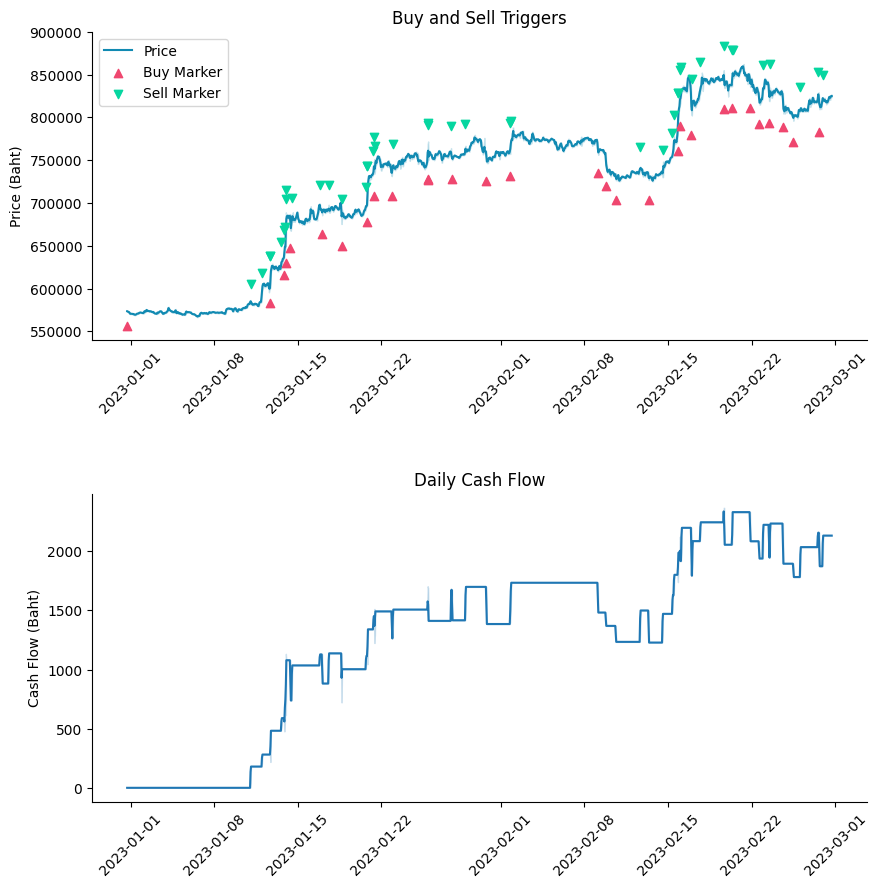

In [40]:
get_chart(df=full_df)

From the illustration:
- the first chart shows the buy (🔴) and sell (🟢) triggers at each price.

- the second chart exhibits the accumulative cash flow over period of times.